# Homework 4 - Clustering and Hash Functions
## Claudio Battiloro, Melis Kaymaz ,  Mahtab Fotovat

We've choosen to run the analysis creating a function for every request. We've done this in order to make the code clearier and easier to understand. Of course, it's also permits to modify single requestes without changing the entire code and don't worrying about memory issues. All this funtions are stored in the following .py:

In [3]:
import hw4_lib as h

Here other useful libs:

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from PIL import Image
from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud, ImageColorGenerator


# 1. Does basic house information reflect house's description?

![alt text](https://kopywritingkourse.com/wp-content/uploads/how-to-write-an-airbnb-description-house.png "Casssh")

In this assignment we will perform a clustering analysis of house announcements in Rome from Immobiliare.it.

## Goal 

We will implement two clustering and compare the results we get. We will need to create two datasets and each of them will be filled by data that we scraped.

## Scraping

This time, we created our dataset. The website that we scraped is ***immobiliare.it***. In particular, we retrieved all the possible announcements starting from the indicated link until the last page. We made it by using this function that starts from the first URL and returns a well organized data frame containing the requested infos for every announcement.

Of course, they're a lot (about 41000) so we decided, in order to avoid serious computational issues, to make clustering on the first 15000 announcments.



In [1]:
mat_complete = h.create_data()

Let's take a look to this DF:

In [4]:
mat_complete.head()

,url,price,locali,superficie,bagni,piano,description
1,https://www.immobiliare.it/nuove_costruzioni/R...,448500.0,3,46,None,None,\n\n Le residen...
2,https://www.immobiliare.it/53131931-Vendita-Bi...,225000.0,2,50,1,1,\n\n PAPILLO EU...
3,https://www.immobiliare.it/70420586-Vendita-Bi...,229000.0,2,70,1,5,\n\n Prenestina...
4,https://www.immobiliare.it/70288308-Vendita-Ap...,690000.0,5,140,2,2,\n\n Nelle vici...
5,https://www.immobiliare.it/70114826-Vendita-Tr...,520000.0,3,105,2,1,\n\n Proponiamo...


Now it's pretty clear that from this df we can easily build the requested following matrices.




## Datasets

### 1.1 Information

The first matrix has this format: $m_{ij} = value$ where $i \in \{announcement_1, ..., announcement_n\}$ and $j \in \{price, locali, superficie, bagni, piano \}$. $n$ is the number of the announcements. 

We have this matrix yet, it's enough to cut the columns in range $[1,5]$ from the complete previous DF.


In [105]:
mat_complete.iloc[:,1:6].head()

,price,locali,superficie,bagni,piano
1,448500.0,3,46,None,None
2,225000.0,2,50,1,1
3,229000.0,2,70,1,5
4,690000.0,5,140,2,2
5,520000.0,3,105,2,1


As we can see, there are some *None* values that we need to clear and in order to do this we implemented a function that replaces with NAs the rows that contain them or other non useful or not easy handling data in clustering(as announcements with a range for a specific feature and not a single number or with not numerical values, such as $A$ (attico) or $S$ (seminterrato) for "piano"). Obviously, to get the final matrix we just delete the rows made by NAs.
The procedure is vectorized.

In [4]:
mat = mat_complete.iloc[:,1:6].apply(h.to_numeric_2, axis = 1)
final_ann_idx = (pd.isna(mat["price"]) == False) # This takes track of the choosen indeces to make the
                                                 # second matrix consistent with this one
mat = mat.loc[final_ann_idx]

Let's take a look:

In [107]:
mat.head()

,bagni,locali,piano,price,superficie
2,1.0,2.0,1,225000.0,50.0
3,1.0,2.0,5,229000.0,70.0
4,2.0,5.0,2,690000.0,140.0
5,2.0,3.0,1,520000.0,105.0
6,2.0,3.0,2,419000.0,100.0


Exactly what we want.


### 1.2 Description

The second matrix have this format: $m_{ij} = tfIdf_{ij}$ where $i \in \{announcement_1, ..., announcement_n\}$ and $j \in \{word_1, ...,word_m\}$. $n$ is the number of the announcements and $m$ is the cardinality of the vocabulary.

In order to build this matrix, we have to select all the descriptions from the first DF, pre-process them, compute the $TFiDF$ score and organize the results in a DF.

We can start with pre-processing by using a function that takes the data(the description slice of DF) and returns the preprocessed slice.



In [56]:
mat_desc_txt = mat_complete.loc[final_ann_idx].iloc[1:15000,6] # Here we cut and select only the rows 
                                                               # that are also in the first matrix
mat_desc = mat_desc_txt.apply(h.preProcessing)


Let's take a look:

In [57]:
mat_desc.head()

3    [prenestin, appart, vend, adiacent, larg, pren...
4    [nell, vicin, parc, appi, antic, via, ardeatin...
5    [propon, vend, via, genser, fontan, immobil, 1...
6    [rif, cortin, dampezz, 419, nell, rinom, corni...
7    [nel, quart, prat, vie, import, zon, propon, v...
Name: description, dtype: object

Now we have to compute (do you remember Homework3? :D) two inverted indices, the vocabulary and the idf in order to build the final matrix. The functions are almost the same with just some minor changes to let them work on this format.

In [43]:
vocabulary = h.create_vocabulary(mat_desc)
inverted_index = h.create_inverted_index(mat_desc)

idfi = []
for word in vocabulary:
    idfi.append(h.IDFi(word, inverted_index, len(mat_desc)))
    
inverted_index2 = h.create_inverted_index_with_TFIDF(mat_desc ,vocabulary, idfi)



Now we use a function that takes all the aforementioned objects and returns the final matrix. Check the lib for the technical explanation of the function (it's pretty dumb).

In [ ]:
mat2 = h.second_mat(mat_desc,inverted_index2,inverted_index,vocabulary)

Let's take a look (and convert it to a DF):

In [54]:
mat2 = pd.DataFrame(mat2,columns = vocabulary.keys())
mat2.head()

,prenestin,appart,vend,adiacent,larg,prenest,pian,alto,lumin,ingress,...,302018,recis,incorpor,ddfmuratell,serz,acquaanien,precisam,3491152085,traform,mantend
0,0.018893,0.000125,0.000412,0.010831,0.0721,0.112971,-0.000707,0.027608,0.006225,0.001850,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000082,0.000270,0.000000,0.0000,0.000000,-0.000463,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000407,0.000000,0.0000,0.000000,-0.000698,0.013629,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000128,0.000423,0.011116,0.0000,0.000000,-0.000725,0.014167,0.000000,0.001899,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000199,0.000328,0.000000,0.0000,0.000000,-0.001125,0.010987,0.004954,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Clustering

Now that we have the "points" of interest, we can cluster them using *K-means ++* algorithm and make a brief analysis on the results.
Just to briefly remind what's going on, the *K-means++* provides a slightly suboptimal solution to the following **K-means** clustering problem.

Given the dataset $X$ consisting of points $\in \mathbb{R}^D$, the goal is to partition the data set into some number $K$ of clusters. We can formalize this notion by first introducing a set of D-dimensional vectors $\mathbf{c}_k,\,k=1,...,K$ whose represent the centroids, so the centers of the clusters. Our goal is then to find an assignment of data points to clusters, as well as a set of vector $\{\mathbf{c}_k\}$, such that the sum of the squares of the distances of each data point to its closest vector $\mathbf{c}_k$, is a minimum.
It's convenient at this point to define some notation to describe the assignement of data points to clusters. For each data point $\mathbf{x}_n$, we introduce a corresponding set of binary indicator variables $r_{nk} \in \{0,1\}$, where $k=1,...,K$, describing which of the $K$ clusters the data point $\mathbf{x}_n$ is assigned to, so that if data point $\mathbf{x}_n$ is assigned to cluster $k$ then $r_{nk}=1$ and $r_{nj}=0$ for $j \neq k$. In the end, the goal is now defined as:
$$[\{r_{n,k}\}^*, \mathbf{c}^*] = min_{\{r_{n,k}\}, \mathbf{c}} \sum_{i=1}^N \sum_{k=1}^K r_{nk} ||x_i - c_k||^2$$

Another,more compact but not less formal way to define the problem, in order to keep it more easily in mind is the followig.

For the **K-means** problem, we are given an integer $K$ and a set of $N$ data points $\mathbf{x} \in \mathbb{R}^D$. The goal is choosing $K$ centers $C$ so as to minimize the potential function:
$$J = \sum_{i=1}^N min_{\mathbf{c} \in C} ||\mathbf{x}_i - \mathbf{c}||^2$$

This is an ***NP-Hard*** problem and it's approximately solved using an iterative algorithm - Loyd's Algorithm-. *K-means++* improves the algorithm by providing a guaranteed performances initialization method to Loyd's alg.

### Elbow Method
In order to choose the optimal number of clusters $k$, we implemented a function that takes the matrix of points and the maximum number of clusters and shows us the value of the cost function as $k$ varies. 

Using the *Elbow Method* we're going to define $k_{opt}$ as the value after which the curve decreases more slowly ( so higher numbers of cluster will not improve the situation, we're interested in the smallest number of clusters among the ones associated to a small error $\iff$ value of the cost function).

### $1^{st}$  Clustering: Information
First of all, we've to find $k_{opt}$:



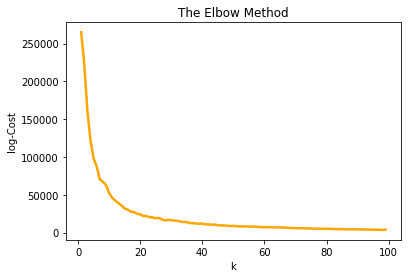

In [55]:
h.elbow_method(mat,k_max = 100)

It seems that a good choice in our case can be $k = 15 $. Now we can cluster:

In [70]:
mat_clustering = KMeans(n_clusters = 15, precompute_distances=True,).fit(mat)

Of course it's not easy to visualize the clusters due to the high dimension of observations (5 features for each announcement) but we can try to project the point on a sub-space of dimension 3 using only $\{price,bagni,locali\}$

In [ ]:
mat.head()

We can try to visualize the clusters but it will be really hard, because the only way to do it is project the points on a features subspace (let's say of dimension 2) and this will not be consistent due to the huge loss of information.
Let's plot the clusters using $\{locali,superficie\}$:

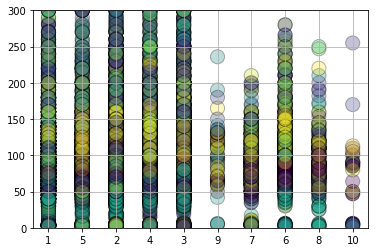

In [87]:
h.clusters_plot(mat_clustering,mat)

Nice, but really meaningless.

### $2^{nd}$ Clustering: Description
Again, we've to find $k_{opt}$ :

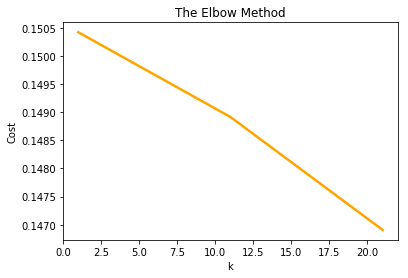

In [9]:
h.elbow_method(mat2,k_max = 20,big_df = 1)

As we can see, the elbow is absolutely not visible using the selected range $[1-20]$. On the other hand, it's computationally impossible to run the clustering process for higher $k$ due to the very huge dimensions of the matrix. Instead, it's possible to understand what's going on and guess which can be an sub-optimal value for $k$.
The matrix is made by points (rows) $\in \mathbf{R}^V$ where $V=length(vocabulary)$ (very high dimension) whose elements are almost all zeros - every announcement contains only a small fraction of the total words in vocabulary- so the clustering does not make too much sense becouse the nonzeros elements are few and on diferrent (possibly distant) components. So' it's clear that the loss function will go down slowly and for very high $k$s,when clusters are really small (we know that the curves goes to zero when each point makes its own cluster).

At this point we've to find a reasonable choice for $k$. A first idea can be choosing a large $k$ to minimize the loss but this is not helpful to compare clusters deriving from the two matrices we have.
So, we decided to choose the same number of cluster used for the first matrix $k_{opt} = 15$.

In [6]:
mat2_clustering = KMeans(n_clusters = 15, precompute_distances=True,n_init= 2, max_iter = 50).fit(mat2)

## Jaccard Similarity

In order to compare the clusters of the two matrices, we need to create two dictionaries indexed with the number of clusters and containing the announcements for each of them.
To do this, we implemented a function that takes a kmeans object and returns the dic.

In [77]:
C1 = h.clusters_dic(mat_clustering)
C2 = h.clusters_dic(mat2_clustering)

The next function takes the two dics, computes all the possible Jaccard Similarities among clusters and return the first $k$ (choosen by user) largest ones with the corresponding number of cluster, obtained by using a *max heap*.

In [49]:
res = h.cluster_jaccard(C1, C2, 3)
res

[(0.21248474989833266, ['mat 1 -> cluster: ', 0, 'mat 2 -> cluster: ', 6]),
 (0.17714168602268068, ['mat 1 -> cluster: ', 10, 'mat 2 -> cluster: ', 6]),
 (0.15170097824499926, ['mat 1 -> cluster: ', 13, 'mat 2 -> cluster: ', 6])]

## WordCloud

Now that we got the clusters of interest, it's time to compute the *wordcloud*.
We need to know which announcements are in both the couple of clusters highlighted above, and we simply get the intersections.

In [50]:
int1 = set(C1[0]).intersection(C2[6])
int2 = set(C1[10]).intersection(C2[6])
int3 = set(C1[2]).intersection(C2[6])

At this point, we implemented a function that takes a list containing the intersections and return a list of the same length which contains large strings made by all the descriptions of the announcements in each intersections.



In [65]:
txt = h.wordcloud([int1,int2,int3],mat_desc_txt)

At this point, we've just to set up the lib and print the wordclouds:

In [74]:
stopwords_ = set(STOPWORDS)
stopwords_.update(stopwords.words("italian"))

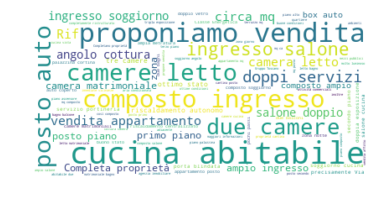

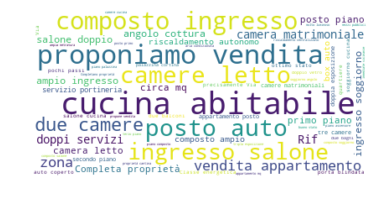

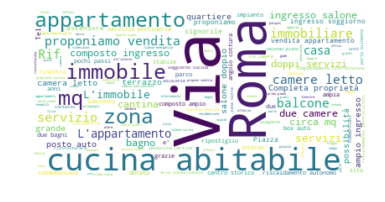

In [106]:
for i in range(3):
    wordcloud = WordCloud(stopwords=stopwords_,background_color='white').generate(txt[i])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Nice, in this way we can observe the most used words and get a nice visual effect.

## K-Means from scratch
Here we present our "handmade" K-Means implementation. It is a class (finally a little bit of OO Programming), so let's instantiate an object containing the clusters of the first mat. We choosen $8$ cluster to have a faster computation.

In [102]:
our_k = h.kmeans(mat,k = 8, max_steps= 110)

To have a comparison we have to recluster the matrix using *sklearn* initialized randomly and not with *K-means ++* procedure. 

In [103]:
mat_clustering_ran = KMeans(n_clusters = 8, precompute_distances=True,init="random").fit(mat)

Clusters might not be numbered in the same way, so we replicate the procedure used above for searching the most similiar clusters using Jaccard Similarity (ideally we hope to find 8 identical pairs $\rightarrow \text{JaccardS = 1}$). Let's create the dics...

In [104]:
C_our = h.clusters_dic(our_k.labels)
C1cazzo = h.clusters_dic(mat_clusteringcazzo.labels_)


... and check the distances.

In [106]:
h.cluster_jaccard(C1cazzo,C_our, k = 8)

[(1.0, ['mat 1 -> cluster: ', 5, 'mat 2 -> cluster: ', 7]),
 (1.0, ['mat 1 -> cluster: ', 4, 'mat 2 -> cluster: ', 6]),
 (1.0, ['mat 1 -> cluster: ', 1, 'mat 2 -> cluster: ', 4]),
 (0.9122227465785748, ['mat 1 -> cluster: ', 6, 'mat 2 -> cluster: ', 0]),
 (0.9110546378653113, ['mat 1 -> cluster: ', 2, 'mat 2 -> cluster: ', 3]),
 (0.818294804871986, ['mat 1 -> cluster: ', 7, 'mat 2 -> cluster: ', 5]),
 (0.7770637666831438, ['mat 1 -> cluster: ', 0, 'mat 2 -> cluster: ', 1]),
 (0.7417156286721505, ['mat 1 -> cluster: ', 3, 'mat 2 -> cluster: ', 2])]

This is a very good result, 3 equals pairs and other 4 pairs similiar at at least $75\%$. It's clear that the ideal result cannot be reached easily, due to the randomic initializations of the two algorithms.

# 2. Find the duplicates!

![alt text](https://cc-media-foxit.fichub.com/image/fox-it-mondofox/73186bba-9cbb-4087-a5d5-62925d32f4b4/matrix-sushi-maxw-654.jpg "This is your last chance. After this, there is no turning back. You take the blue pill—the story ends, you wake up in your bed and believe whatever you want to believe. You take the red pill—you stay in Wonderland, and I show you how deep the rabbit hole goes. Remember: all I'm offering is the truth. Nothing more.")

The idea of hash function is to associate a number to an object(mostly a string) trough a specifical mathematical law (a function, exactly) , so a numbered slot in a table of a certain size which is called "Hash Table". This size is pretty important and, of course in the case we know how many elements have to be hashed, it should be at least as big as the number of the string we wanna map, and we would like that every hashable element will be mapped in a different slot of the hash table. 

So it's important to keep in mind that the size of the table is one of the factor that determines the number of collisions in an hash process, togheter with the goodness of the choosen function.

## 2.1 Order doesn't matter

We are given passwords2.txt file as input. Each row corresponds to a string of 20 characters. We defined a hash function that associates a value to each string. In this case, the goal is to check whether there are some duplicate strings. The first definition of duplicate is that the two strings have the same characters, order is not important. Thus, "AABA" = "AAAB".

In order to achive the request, we designed a first hash function that associates a number to every string by not taking in account the order of the characters in the string and then maps this number in a choosen range(size of the hash table). The function works at bit-level and it is the following:

$$ \mathbf{h}(s) = \mathbf{f}(length(s))\,mod(SIZE)$$

where $\mathbf{f}( \cdot )$ is a recursive function defined as:
$$ \mathbf{f}(n) = (\mathbf{f}(n-1) \oplus \mathbf{g}(s_n)) \cdot k $$ and:

- $s$ is the string.
- $s_i$ is the $i^th$ character of the string.
- $\mathbf{g}(\cdot)$ is a function that maps the character to it's ascii value.
- $k$ is a possible large number.
- $SIZE$ is the dimension of the associated hash table.
- $\oplus$ is the logic operator [XOR](https://en.wikipedia.org/wiki/XOR)
- $f(0) = 0$

As usual in using hash function,the division $mod(SIZE)$ is what effectively maps the number assigned to the string in the choosen dimension of the hash table.
We decided $SIZE = 1787178291199$(wide hash table) becouse it guarantees, for the specified file, very good results.

The first implementation we propose finds duplicates, so strings mapped to the same hash value, ignoring the order of characters. It's a function that takes the path of the file and returns the list of duplicates.





In [24]:
duplicates = h.first_hash("passwords2.txt")

The number of detected duplicates is:

In [26]:
len(duplicates)

10002780

There are about $10M$ duplicates, so it seems working.

## False Positives: "not ordered" case

### $1^{st}$ FPs function: a bit of randomness
In order to find if there are some false positives among the duplicates, so strings that contain different chars mapped to the same value, we propose an improvement on the previous function that return the duplicates and the number of FP (by using ,obviously, the same hash function). 

This function is not always completelly correct becouse it starts counting FPs by comparing the conflicting elements with the first assinged string to a certain hash value. So, if the FP is that first string, it will return a partially incorrected results. The choice of including this function in the homework is motivated by the fact that, within respect to the second FP detecting function we'll propose, this one is faster but with some chances of error. 
As before, the function just takes the path of the file.

In [27]:
fp,duplicates = h.first_hash_e("passwords2.txt")

The numbers of detected false positives and duplicates are:

In [28]:
print("FP =", fp," Duplicates=", len(duplicates))

FP = 0  Duplicates= 10002780


This function cannot detect false positives in this case. So we need another step.

### $2^{nd}$ FPs function

This second FPs detecting function is slower than the first but, as explained in its "doc", surely returns the right false positives number (and the detected duplicates). To avoid computational problems, the procedure is splitted in two parts. The first part is exactly the same function we used to find duplicates but, at this time, it returns also a dictionary (the table) containg the results in the format *(value, passwords associated to value)*. The second part consists in analyzing the table in order to find FPs.

Let's get table and duplicates with the following function which, as usual, takes the path of the file to hash.

In [29]:
duplicates,table = h.first_hash_true("passwords2.txt")

Now we can check for false positives with the following function that takes the table and reutrn FPs.

In [30]:
fp = h.find_fps(table)

The numbers of detected false positive and duplicates are:

In [31]:
print("FPs =", fp," Duplicates=", len(duplicates))

FPs = 2780  Duplicates= 10002780


As we can see, the results are different. We found exactly $10M$ true duplicates, as requested.

## 2.1 Order matters

Now we wanna design an hash function that takes in account also the order of the characters in a string and apply it on the same file "password.txt".
We designed two hash functions, one easier to understand and one other with more solid theoretical fundaments.

### $1^{st}$ function

The first proposed hash function, using the same notation as before, is a polynomial of the form:

$$\mathbf{h}(s) = \Big (\sum_{i = 0}^{length(s)-1} k^i \cdot \mathbf{g}(s_{n-i}) \Big )\,mod(SIZE) $$

where:

- $k$ is a number, possibly **prime**

This function intuitively takes in account the order of the characters becouse gives different weights to chars, and the weights is determined by their order.

Let's check how many duplicates it finds.



In [12]:
duplicates1 = h.o_hash_1("passwords2.txt")

The number of detected duplicates is:

In [13]:
len(duplicates1)

5003118

### $2^{nd}$ function

The second function we propose is a ,let's say, toy implementation of [MD5](https://en.wikipedia.org/wiki/MD5). In particular it operates at bit-level to assign a number to a string and this guarantees that the order of the characters counts and should prevent false-positive. Nowadays it is considered old but it's a good starting point to understand how hash function works.
The function is, again with the same notation:
$$ \mathbf{h}(s) = \mathbf{f}(length(s))\,mod(SIZE)$$

where $\mathbf{f}( \cdot )$ is a recursive function defined as:
$$ \mathbf{f}(n-1) = (\mathbf{f}(n) \cdot A) \oplus (\mathbf{g}(s_n) \cdot B)$$ with $n \in \{1,...,length(s)\}$ and:

- $A =$ prime
- $B =$ prime
- $\mathbf{f}(0)=$ prime
- $\oplus$ is the logic operator [XOR](https://en.wikipedia.org/wiki/XOR)

Let's give it a try and check how many duplicates it founds.


In [9]:
duplicates2 = h.o_hash_2("passwords2.txt")

The number of detected duplicates is:

In [10]:
len(duplicates2)

5003031

As expected, the result is the same, in spite of the two differents approaches. It's interesting to analyze of this two functions face off the false positives problem.

## False Positives : "ordered" case

We implemented a bit of logic in the two previous functions in order to get the number of False Positive. Let's see what happen.

### FPs for $1^{st}$ function




In [16]:
duplicates,fp = h.o_hash_1_fp("passwords2.txt")

The numbers of detected false positive and duplicates are:

In [17]:
print("FP =", fp," Duplicates=", len(duplicates))

FP = 3118  Duplicates= 5003118


### FPs for  $2^{nd}$ function

In [18]:
duplicates,fp = h.o_hash_2_fp("passwords2.txt")

The numbers of detected false positive and duplicates are:

In [19]:
print("FP =", fp," Duplicates=", len(duplicates))

FP = 3030  Duplicates= 5003031


Comparing the two results, we are pretty sure that the file contains $5M$ duplicates taking in account the order of the chars.